<a href="https://colab.research.google.com/github/wxya2017/GR5242-CIFAR10/blob/master/keras_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/5242") 

In [0]:
import cv2
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
# from tensorflow.python.eager import context

import keras
import time

from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras import regularizers, optimizers


In [0]:
import os
import tensorflow as tf
from keras.callbacks import TensorBoard

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [0]:
# Run Tensorflow in the background - note that we specify the log 
# directory we want to look at
LOG_DIR = 'logs_keras'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [7]:
# Launch the ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

# Get the public URL and be sorted!
! curl -s http://localhost:4040/api/tunnels | python3 -c\
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://83db04f6.ngrok.io


In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_data(dir):
    train_x = np.array(unpickle(dir+'data_batch_1')[b'data'])
    train_y = np.array(unpickle(dir+'data_batch_1')[b'labels'])
    for i in range(2,6):
        train_x = np.concatenate((train_x, np.array(unpickle(dir+'data_batch_'+str(i))[b'data'])), axis = 0)
        train_y = np.concatenate((train_y, np.array(unpickle(dir+'data_batch_'+str(i))[b'labels'])),axis = 0)


    test_x = np.array(unpickle(dir+'test_batch')[b'data'])
    test_y = np.array(unpickle(dir+'test_batch')[b'labels'])   
    labels = unpickle(dir+'batches.meta')[b'label_names']
    return train_x, train_y, test_x, test_y, labels

In [0]:
def reshape(image):
    out = np.zeros(shape=[32,32,3])
    for i in range(3):
        out[:,:,i] = image[1024*i:1024*(i+1)].reshape([32,32])
    return out

def pre_process_x(x):
    new_x = np.zeros(shape=[len(x),32,32,3])
    for i in range(len(x)):
        new_x[i] = reshape(x[i])
    new_x = new_x/255
    return new_x

def pre_process_y(y):
    new_y = np.zeros([len(y),10])
    for i in range(len(y)):
        new_y[i][y[i]] = 1
    return new_y

In [12]:
ori_train_x, ori_train_y, ori_test_x, ori_test_y, labels = load_data('data/')

train_x = pre_process_x(ori_train_x)
test_x = pre_process_x(ori_test_x)
train_y = pre_process_y(ori_train_y)
test_y = pre_process_y(ori_test_y)
print("===>training data shape is "+ str(train_x.shape))
print("===>test data shape is "+ str(test_x.shape))
print("===>training label shape is "+ str(train_y.shape))
print("===>test label shape is "+ str(test_y.shape))

===>training data shape is (50000, 32, 32, 3)
===>test data shape is (10000, 32, 32, 3)
===>training label shape is (50000, 10)
===>test label shape is (10000, 10)


In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )

# baseline

In [0]:
def build_model_base(num_classes = 10, baseMapNum = 32):
    '''build weight decay model'''
    model_base = Sequential()
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv1', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=train_x.shape[1:]))
    model_base.add(Activation('relu', name='relu1'))
    
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv2', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu2'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp1'))
    model_base.add(Dropout(0.5, name='drop1'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv3', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu3'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv4', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu4'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp2'))
    model_base.add(Dropout(0.3, name='drop2'))


    model_base.add(Flatten())
    model_base.add(Dense(num_classes, activation='softmax', name='dense'))
    
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model_base


In [0]:
model_base = build_model_base()
print(model_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
__________

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_baseline_ep250', write_graph=True)
datagen.fit(train_x)
#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
fit_history_base = model_base.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                            steps_per_epoch=iterations,
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(valid_x,valid_y),
                                            callbacks=[tbCallBack])
                    
model_base.save('model/model_baseline_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

In [0]:
# plot_model_history(fit_history1)
baseline_evalu = model_base.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = baseline_evalu[1]; loss = baseline_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

# model_decay_test = load_model('model/model_weight_decay_test.h5')

10000/10000 [==============================] - 1s 114us/step

Test result: 64.150 loss: 1.249


Text(69,0.5,'Predicted label')

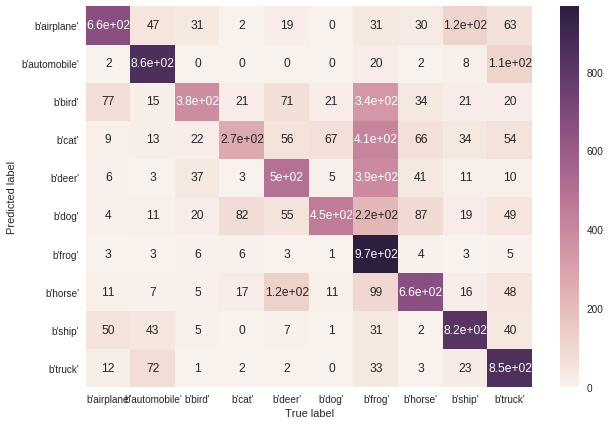

In [0]:
y_prob_base = model_base.predict(test_x) 
y_pred_base = y_prob_base.argmax(axis=-1)
y_true = np.where(test_y == 1)[1]
cm = confusion_matrix(y_true, y_pred_base, labels = range(10))
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')

# more layers, batchnorm,adadelta optimizer

In [0]:
def build_model_batchnorm_adadelta(num_classes = 10, baseMapNum = 32, weight_decay = 1e-4):
    '''build weight decay model'''
    model = Sequential()
    
    model.add(Conv2D(baseMapNum, (3,3), name='conv1', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_x.shape[1:]))
    model.add(BatchNormalization(name='batchn1'))
    model.add(Activation('relu', name='relu1'))
    
    model.add(Conv2D(2*baseMapNum, (5,5), name='conv2', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxp1'))
    model.add(Dropout(0.2, name='drop1'))
    
    model.add(Conv2D(2*baseMapNum, (5,5), name='conv3', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn3'))    
    model.add(Activation('relu', name='relu3'))

    model.add(Conv2D(3*baseMapNum, (3,3), name='conv4', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxp2'))
    model.add(Dropout(0.3, name='drop2'))

    model.add(Conv2D(4*baseMapNum, (3,3), name='conv5', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn5'))
    model.add(Activation('relu', name='relu5'))

    model.add(Conv2D(4*baseMapNum, (5,5), name='conv6', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxp3'))
    model.add(Dropout(0.4, name='drop3'))

    model.add(Conv2D(2*baseMapNum, (3,3), name='conv7', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization(name='batchn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxp4'))
    model.add(Dropout(0.4, name='drop4'))
    
    model.add(Flatten(name='flat1'))
    model.add(Dense(num_classes, activation='softmax', name='dense1'))
    
    opt = optimizers.Adadelta()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [0]:
model_batchnorm_adad = build_model_batchnorm_adadelta()

In [0]:
print(model_batchnorm_adad.summary())

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_batchnorm_adad_ep250',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_batchnorm_250 = model_batchnorm_adad.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                                          steps_per_epoch=iterations,
                                                          epochs=epochs,
                                                          verbose=1,
                                                          validation_data=(valid_x,valid_y),
                                                          callbacks=[tbCallBack])
end = time.time()
model_batchnorm_adad.save('model/model_batchnorm_adad_ep250.h5')
print("Model took %0.2f seconds to train"%(end - start))

In [0]:
# plot_model_history(fit_history1)
batchnorm_adad_evalu = model_batchnorm_adad.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = batchnorm_adad_evalu[1]; loss = batchnorm_adad_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

# model_decay_test = load_model('model/model_weight_decay_test.h5')

10000/10000 [==============================] - 2s 206us/step

Test result: 76.960 loss: 1.078


Text(69,0.5,'Predicted label')

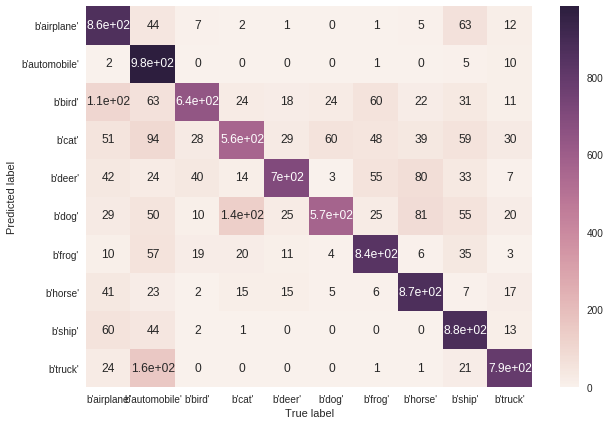

In [0]:
y_prob_base = model_batchnorm_adad.predict(test_x) 
y_pred_base = y_prob_base.argmax(axis=-1)
y_true = np.where(test_y == 1)[1]
cm = confusion_matrix(y_true, y_pred_base, labels = range(10))
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')

# NIN base

In [0]:
def build_model_NIN_base(num_classes = 10, baseMapNum = 32):
    '''build NIN model: 
       1.convolution layer followed by 2 1*1 convlution layer(mlp)
       2.end with 10 filters mlp, averagepooling, softmax
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp1_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*3, (1,1), name='mlp1_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp1'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(num_classes, (1,1), name='mlp2_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu6'))
    
    model.add(GlobalAveragePooling2D(name='avgp1'))
    model.add(Activation('softmax'))
    
    opt = optimizers.Adadelta()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


In [0]:
NIN_base = build_model_NIN_base()

In [0]:
print(NIN_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 192)       14592     
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 192)       0         
_________________________________________________________________
mlp1_1 (Conv2D)              (None, 32, 32, 160)       30880     
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 160)       0         
_________________________________________________________________
mlp1_2 (Conv2D)              (None, 32, 32, 96)        15456     
_________________________________________________________________
relu3 (Activation)           (None, 32, 32, 96)        0         
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 16, 16, 96)        0         
__________

**250 epochs**

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_NIN_base_ep250',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_base = NIN_base.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                              steps_per_epoch=iterations,
                                              epochs=epochs,
                                              verbose=1,
                                              validation_data=(valid_x,valid_y),
                                              callbacks=[tbCallBack])
NIN_base.save('model/model_nin_base_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))


In [0]:
# plot_model_history(fit_history1)
NIN_base_evalu =NIN_base.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = NIN_base_evalu[1]; loss = NIN_base_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))


10000/10000 [==============================] - 6s 567us/step

Test result: 74.010 loss: 1.038


# nin base2

In [0]:
def build_model_NIN_base2(num_classes = 10, baseMapNum = 32):    # no dropout
    '''build NIN model: 
       1.convolution layer followed by 2 1*1 convlution layer(mlp)
       2.end with 10 filters mlp, averagepooling, softmax
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp1_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*3, (1,1), name='mlp1_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp1'))
    
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(num_classes, (1,1), name='mlp2_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu6'))
    
    model.add(GlobalAveragePooling2D(name='avgp1'))
    model.add(Activation('softmax'))
    
    opt = optimizers.Adadelta()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


In [0]:
NIN_base2 = build_model_NIN_base2()

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_NIN_base2_ep250',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_base2 = NIN_base2.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                              steps_per_epoch=iterations,
                                              epochs=epochs,
                                              verbose=1,
                                              validation_data=(valid_x,valid_y),
                                              callbacks=[tbCallBack])
NIN_base2.save('model/model_nin_base2_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))


In [19]:
# plot_model_history(fit_history1)
NIN_base2_evalu = NIN_base2.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = NIN_base2_evalu[1]; loss = NIN_base2_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

10000/10000 [==============================] - 3s 301us/step

Test result: 74.620 loss: 1.067


# NIN

In [0]:
def build_model_NIN_sgd(num_classes = 10, baseMapNum = 32):
    '''build NIN model: 
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(BatchNormalization(name='batchn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp1_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*3, (1,1), name='mlp1_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp1'))
#     model.add(Dropout(0.5, name='drop1'))
    
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp2'))
#     model.add(Dropout(0.5, name='drop2'))
    
    model.add(Conv2D(baseMapNum*6, (3,3), name='conv3', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp3_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn8'))
    model.add(Activation('relu', name='relu8'))
    model.add(Conv2D(num_classes, (1,1), name='mlp3_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn9'))
    model.add(Activation('relu', name='relu9'))
    
    model.add(GlobalAveragePooling2D(name='avgp1'))
    model.add(Activation('softmax'))
    
    opt = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

def scheduler(epoch):
    if epoch <= 80:
        return 0.01
    if epoch <= 160:
        return 0.001
#     return 0.0001   previous
    return 0.0005

In [21]:
NIN_sgd = build_model_NIN_sgd()
print(NIN_sgd.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 192)       14592     
_________________________________________________________________
batchn1 (BatchNormalization) (None, 32, 32, 192)       768       
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 192)       0         
_________________________________________________________________
mlp1_1 (Conv2D)              (None, 32, 32, 160)       30880     
_________________________________________________________________
batchn2 (BatchNormalization) (None, 32, 32, 160)       640       
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 160)       0         
_________________________________________________________________
mlp1_2 (Conv2D)              (None, 32, 32, 96)        15456     
__________

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_NIN_sgd_ep250',write_graph=True)
change_lr = LearningRateScheduler(scheduler)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_sgd_250 = NIN_sgd.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                        steps_per_epoch=iterations,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=(valid_x,valid_y),
                                        callbacks=[change_lr, tbCallBack])
NIN_sgd.save('model/model_nin_sgd_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

In [24]:
NIN_sgd_evalu = NIN_sgd.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = NIN_sgd_evalu[1]; loss = NIN_sgd_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

10000/10000 [==============================] - 5s 455us/step

Test result: 84.640 loss: 0.621


In [0]:
# NIN_sgd = load_model('model/model_nin_sgd_ep250.h5')

In [0]:
# from keras.utils.vis_utils import plot_model

In [0]:
# plot_model(NIN_sgd, to_file='model/nin_sgd_ep250.png', show_shapes=True, show_layer_names=True)

nin deep scheduler2

In [0]:
def build_model_NIN_deep(num_classes = 10, baseMapNum = 32):
    '''build NIN model: 
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(BatchNormalization(name='batchn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp1_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*3, (1,1), name='mlp1_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp1'))
#     model.add(Dropout(0.5, name='drop1'))
    
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp2'))
#     model.add(Dropout(0.5, name='drop2'))
    
    
    model.add(Conv2D(baseMapNum*5, (3,3), name='conv3', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp3_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn8'))
    model.add(Activation('relu', name='relu8'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp3_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn9'))
    model.add(Activation('relu', name='relu9'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp3'))
#     model.add(Dropout(0.5, name='drop3'))
    
    model.add(Conv2D(baseMapNum*5, (3,3), name='conv4', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn10'))
    model.add(Activation('relu', name='relu10'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp4_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn11'))
    model.add(Activation('relu', name='relu11'))
    model.add(Conv2D(num_classes, (1,1), name='mlp4_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn12'))
    model.add(Activation('relu', name='relu12'))
    
    model.add(GlobalAveragePooling2D(name='avgp1'))
    model.add(Activation('softmax'))
    
    opt = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

In [0]:
def scheduler2(epoch):
    if epoch <= 80:
        return 0.01
    if epoch <= 160:
        return 0.005
    return 0.001

In [0]:
NIN_deep2 = build_model_NIN_deep()

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/model_NIN_deep2_ep250',write_graph=True)
change_lr2 = LearningRateScheduler(scheduler2)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_deep2_250 = NIN_deep2.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                        steps_per_epoch=iterations,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=(valid_x,valid_y),
                                        callbacks=[change_lr2, tbCallBack])
NIN_deep2.save('model/model_nin_deep2_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

Epoch 1/250
312/312 [==============================] - 60s 191ms/step - loss: 1.9242 - acc: 0.3787 - val_loss: 2.3173 - val_acc: 0.2895
Epoch 2/250
312/312 [==============================] - 55s 178ms/step - loss: 1.6235 - acc: 0.4915 - val_loss: 2.1265 - val_acc: 0.3555
Epoch 3/250
312/312 [==============================] - 55s 176ms/step - loss: 1.4674 - acc: 0.5465 - val_loss: 1.9122 - val_acc: 0.4268
Epoch 4/250
312/312 [==============================] - 55s 177ms/step - loss: 1.3702 - acc: 0.5787 - val_loss: 1.8597 - val_acc: 0.4386
Epoch 5/250
312/312 [==============================] - 55s 176ms/step - loss: 1.2952 - acc: 0.6060 - val_loss: 1.4748 - val_acc: 0.5613
Epoch 6/250
312/312 [==============================] - 55s 176ms/step - loss: 1.2360 - acc: 0.6256 - val_loss: 2.3351 - val_acc: 0.3620
Epoch 7/250
312/312 [==============================] - 55s 177ms/step - loss: 1.1870 - acc: 0.6439 - val_loss: 1.5387 - val_acc: 0.5230
Epoch 8/250
312/312 [===========================

# 中间层输出

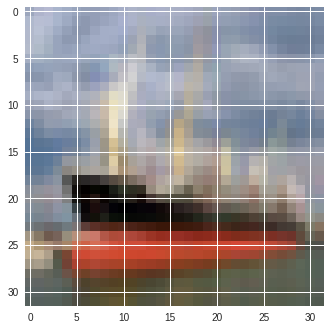

In [0]:
plt.imshow(train_x[5])

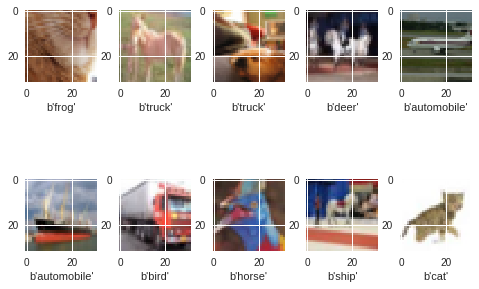

In [0]:
fig, axes = plt.subplots(2, 5)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
    # Plot image and smooth it
    ax.imshow(train_x[i])
    label = labels[ori_train_y[i]]
    ax.set_xlabel(label)

In [0]:
from keras.models import Model
model = load_model('model/model_nin_ep250.h5')  

In [0]:
print(model.summary())

In [0]:
layer_name = 'conv1'
intermediate_layer_model = Model(inputs=model.input,                 
                                 outputs=model.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(train_x[5:6])#这个数据就是原始模型的输入数据，

In [0]:
intermediate_output.shape

(1, 8, 8, 10)

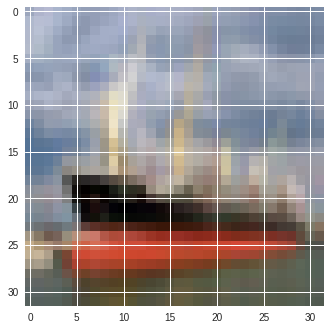

In [0]:
plt.imshow(train_x[5])

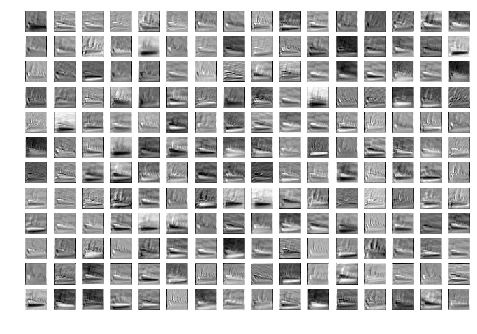

In [0]:
for _ in range(192):
    show_img = intermediate_output[:,:,:, _]
    show_img.shape = [32, 32]
    plt.subplot(12, 16, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

# NIN: mlp(10 class) output

In [0]:
a = np.array([np.where(test_y[i,]==1)[0][0] for i in range(len(test_y))]) #label of each train data
index = [np.where(a==i)[0][1] for i in range(10)] #get a index for each category

In [0]:
test_y[index]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [0]:
layer_name = 'relu9'
intermediate_layer_model = Model(inputs=model.input,                 
                                 outputs=model.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(test_x[index])#这个数据就是原始模型的输入数据，

In [0]:
intermediate_output.shape

(10, 8, 8, 10)

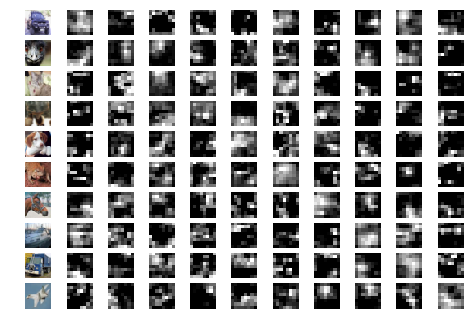

In [0]:
for i in range(10):
    plt.subplot(10,11,i*11+1)
    plt.imshow(test_x[index[i]])
    plt.axis('off')
    for j in range(10):
        show_img = intermediate_output[i,:,:, j]
        show_img.shape = [8, 8]
        plt.subplot(10, 11, i*10+_+i+2)
        plt.imshow(show_img, cmap='gray')
        plt.axis('off')
plt.show()

In [0]:
model.predict_classes(test_x[index])

array([0, 8, 2, 3, 4, 5, 6, 7, 8, 9])

**data augmentation visualization**

In [0]:
data_aug_x = np.zeros((9,32,32,3))
data_aug_y = np.zeros((9,10))
for i in range(9):
    data_aug_x[i] = train_x[0]
    data_aug_y[i] = train_y[0]

In [0]:
datagen.fit(data_aug_x)

In [0]:
for x_batch, y_batch in datagen.flow(data_aug_x, data_aug_x, batch_size=9):
    plt.subplot(4,3,1)
    plt.imshow(data_aug_x[0], cmap='gray')
    plt.axis('off')
    for i in range(9):
        plt.subplot(4,3,i+4)
        plt.imshow(x_batch[i], cmap='gray')
        plt.axis('off')
    plt.show()
    break